## this is purely for tranforming the data and training and testing models

In [1]:
#import libraries
import sqlite3
import pandas as pd
import plotly.express as px
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer, MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
import math
#connect to the data.db database
conn = sqlite3.connect('data.db')
cursor = conn.cursor()

In [2]:
#importing all the tables in the database
outcomes_df = pd.read_sql_query("select * from Outcomes", conn)
clients_df = pd.read_sql_query("select * from Clients", conn)
campaigns_df = pd.read_sql_query("select * from Campaigns", conn)
accounts_df = pd.read_sql_query("select * from Accounts", conn)

In [3]:
#joining the tables based on foreign keys
query = """
SELECT
c.id AS client_id,
c.age,
c.job,
c.marital,
c.education,
a.balance,
a.in_default,
a.housing,
a.loan,
ca.duration,
ca.campaign,
ca.pdays,
ca.previous,
o.poutcome,
o.y
FROM Clients c
JOIN Accounts a ON c.id = a.client_id
JOIN Campaigns ca ON a.id = ca.account_id
JOIN Outcomes o ON ca.id = o.campaign_id;
"""

# Execute the query and fetch the result into a DataFrame
merged_df = pd.read_sql_query(query, conn)
merged_df

,client_id,age,job,marital,education,balance,in_default,housing,loan,duration,campaign,pdays,previous,poutcome,y
0,4815378,58,management,married,tertiary,2143.0,no,yes,no,261,1,-1,0,unknown,unknown
1,5217541,44,technician,single,secondary,29.0,no,yes,no,151,1,-1,0,unknown,unknown
2,6654642,33,entrepreneur,married,secondary,2.0,no,yes,yes,76,1,-1,0,unknown,unknown
3,1421898,47,blue-collar,married,unknown,1506.0,no,yes,no,92,1,-1,0,unknown,unknown
4,2387933,33,unknown,single,unknown,1.0,no,no,no,198,1,-1,0,unknown,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,6145087,51,technician,married,tertiary,825.0,no,no,no,977,3,-1,0,unknown,unknown
45207,8051149,71,retired,divorced,primary,1729.0,no,no,no,456,2,-1,0,unknown,unknown
45208,9198356,72,retired,married,secondary,5715.0,no,no,no,1127,5,184,3,success,unknown
45209,3187020,57,blue-collar,married,secondary,668.0,no,no,no,508,4,-1,0,unknown,unknown


In [4]:
#picking out rows where they said subscribed to deposit and did not and also unknown values
condition = (merged_df.y == 'yes') | (merged_df.y =='no')
condition2 = (merged_df.y=='unknown') 
y_with_outcome = merged_df[condition]
y_unknown = merged_df[condition2] #unknown


In [5]:
# Define the conditions for categorizing ages
conditions = [
    merged_df['age'] < 35,
    (merged_df['age'] >= 35) & (merged_df['age'] < 60),
    merged_df['age'] >= 60
]

# Define the corresponding categories
choices = ['young', 'middle', 'old']

# Apply the conditions and create a new column for age categories
merged_df['age_category'] = np.select(conditions, choices, default='unknown')
merged_df = merged_df.drop(['age'],axis=1)

In [6]:
merged_df.columns

Index(['client_id', 'job', 'marital', 'education', 'balance', 'in_default',
       'housing', 'loan', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'y', 'age_category'],
      dtype='object')

In [7]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Select the columns to be one-hot encoded
columns_to_encode = ['job', 'education','marital','poutcome','age_category']  # Fix: Separate the column names into a list

# Initialize the OneHotEncoder
ohe_encoder = OneHotEncoder(handle_unknown='ignore')  # drop='first' avoids the dummy variable trap

# Apply the encoder to the specified columns
encoded_data = ohe_encoder.fit_transform(merged_df[columns_to_encode])

# Convert the encoded data to a DataFrame
encoded_columns = ohe_encoder.get_feature_names_out(columns_to_encode)

# Convert the sparse matrix to a dense array
encoded_dense = encoded_data.toarray()

# Create a DataFrame from the dense array with appropriate column names
encoded_df = pd.DataFrame(encoded_dense, columns=encoded_columns)
encoded_df.columns

Index(['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown', 'age_category_middle',
       'age_category_old', 'age_category_young'],
      dtype='object')

In [8]:
# Reset index for both DataFrames
merged_df = merged_df.reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)

# Perform horizontal concatenation
horizontal_concat = pd.concat([merged_df, encoded_df], axis=1)
ohe_df = horizontal_concat
ohe_df = ohe_df.drop(['job', 'education','marital','poutcome','age_category'], axis=1)

In [9]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

ohe_df['housing'] = label_encoder.fit_transform(ohe_df['housing'])
print('HOUSING converted to number: ')
mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(mapping)
print()
print('--------------------------------')

ohe_df['loan'] = label_encoder.fit_transform(ohe_df['loan'])
print('LOAN converted to number: ')
mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(mapping)
print()
print('--------------------------------')

ohe_df['y'] = label_encoder.fit_transform(ohe_df['y'])
print('Y converted to number: ')
mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(mapping)
print()
print('--------------------------------')

HOUSING converted to number: 
{'no': 0, 'yes': 1}

--------------------------------
LOAN converted to number: 
{'no': 0, 'yes': 1}

--------------------------------
Y converted to number: 
{'no': 0, 'unknown': 1, 'yes': 2}

--------------------------------


In [10]:
#transforming values into log scale to deal with outliers
ohe_df['duration'] = ohe_df['duration'].apply(
    lambda x: 0 if x <=0 else
              np.log(1+x)  )
print('DURATION made logaritmic (zero for balance <1): ')
print()
print('--------------------------------')

ohe_df['balance'] = ohe_df['balance'].apply(
    lambda x: 0 if x <=0 else
              np.log(1+x)  )
print('BALANCE made logaritmic (zero for balance <1): ')
print()
print('--------------------------------')

columns_transform = ['balance','duration','campaign','pdays','previous']
scaler = MinMaxScaler()
ohe_df[columns_transform] = scaler.fit_transform(ohe_df[columns_transform])
ohe_df

DURATION made logaritmic (zero for balance <1): 

--------------------------------
BALANCE made logaritmic (zero for balance <1): 

--------------------------------


,client_id,balance,in_default,housing,loan,duration,campaign,pdays,previous,y,...,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age_category_middle,age_category_old,age_category_young
0,4815378,0.665029,no,1,0,0.655033,0.000000,0.000000,0.000000,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,5217541,0.294885,no,1,0,0.590985,0.000000,0.000000,0.000000,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,6654642,0.095250,no,1,1,0.510984,0.000000,0.000000,0.000000,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1421898,0.634462,no,1,0,0.533193,0.000000,0.000000,0.000000,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,2387933,0.060096,no,0,0,0.622679,0.000000,0.000000,0.000000,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,6145087,0.582331,no,0,0,0.809978,0.032258,0.000000,0.000000,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
45207,8051149,0.646427,no,0,0,0.720478,0.016129,0.000000,0.000000,1,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
45208,9198356,0.750047,no,0,0,0.826764,0.064516,0.212156,0.010909,1,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45209,3187020,0.564054,no,0,0,0.733155,0.048387,0.000000,0.000000,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [11]:
ohe_df.columns

Index(['client_id', 'balance', 'in_default', 'housing', 'loan', 'duration',
       'campaign', 'pdays', 'previous', 'y', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'education_primary',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown', 'age_category_middle', 'age_category_old',
       'age_category_young'],
      dtype='object')

In [12]:
#splitting ohe_df based on y knowns and y unknowns
condition = (ohe_df.y == 2) | (ohe_df.y ==0)
y_known = ohe_df[condition]
y_known = y_known.drop(['in_default'], axis=1)
y_known

,client_id,balance,housing,loan,duration,campaign,pdays,previous,y,job_admin.,...,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age_category_middle,age_category_old,age_category_young
7,5561468,0.095250,1,0,0.699082,0.000000,0.000000,0.000000,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
9,5203129,0.553745,1,0,0.473523,0.000000,0.000000,0.000000,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
14,6633578,0.441630,1,0,0.607560,0.000000,0.000000,0.000000,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
30,9718018,0.583788,0,1,0.637645,0.000000,0.000000,0.000000,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
33,1174906,0.000000,1,0,0.638165,0.000000,0.000000,0.000000,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45160,4645105,0.000000,1,0,0.736796,0.000000,0.111239,0.018182,2,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
45173,2354794,0.597241,0,0,0.562193,0.048387,0.120413,0.025455,0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
45191,9424440,0.714900,1,0,0.655481,0.000000,0.211009,0.003636,2,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
45197,2721327,0.634749,1,0,0.659006,0.000000,0.000000,0.000000,2,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [13]:
#splitting ohe_df based on y knowns and y unknowns
condition2= (ohe_df.y == 1)
y_unknown = ohe_df[condition2]
y_unknown = y_unknown.drop(['y','in_default'], axis=1)
y_unknown

,client_id,balance,housing,loan,duration,campaign,pdays,previous,job_admin.,job_blue-collar,...,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age_category_middle,age_category_old,age_category_young
0,4815378,0.665029,1,0,0.655033,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,5217541,0.294885,1,0,0.590985,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,6654642,0.095250,1,1,0.510984,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1421898,0.634462,1,0,0.533193,0.000000,0.000000,0.000000,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,2387933,0.060096,0,0,0.622679,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,6145087,0.582331,0,0,0.809978,0.032258,0.000000,0.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
45207,8051149,0.646427,0,0,0.720478,0.016129,0.000000,0.000000,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
45208,9198356,0.750047,0,0,0.826764,0.064516,0.212156,0.010909,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45209,3187020,0.564054,0,0,0.733155,0.048387,0.000000,0.000000,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [14]:
#splitting dataset into test and train sets
columns_in_df = ohe_df.columns
X = y_known[['client_id', 'balance', 'housing', 'loan', 'duration',
       'campaign', 'pdays', 'previous', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'education_primary',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown', 'age_category_middle', 'age_category_old',
       'age_category_young']]
y = y_known[['y']]
X.shape, y.shape

((4521, 34), (4521, 1))

In [15]:
y[y==2]=1

C:\Users\rukhm\AppData\Local\Temp\ipykernel_27008\1051835492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y==2]=1
C:\Users\rukhm\AppData\Local\Temp\ipykernel_27008\1051835492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y==2]=1


In [16]:
y.shape

(4521, 1)

In [17]:
from sklearn import svm 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [18]:
# def cv_svm(xtrain: np.ndarray, ytrain: np.ndarray) -> GridSearchCV:
#     """Train and cross-validate a soft-margin SVM classifier with the grid search.

#     Define an SVM classifier. Use the grid search and a 5-fold cross-validation
#     to find the best value for the hyperparameters 'C' and 'kernel'.

#     Args:
#         xtrain (np.ndarray): The training data.
#         ytrain (np.ndarray): The training labels.

#     Returns:
#         GridSearchCV: The trained model that was cross-validated with the grid search.
#     """
#     # 6.1. define dictionary with parameter grids
#     #C_values = {'C' : np.logspace(-2, 4, num=6), 'kernel': ['linear', 'rbf', 'poly']} #use only the exponents since it is already to teh base 10

#     C_values = {'C': [10**i for i in range(-2, 4, 1)], 'kernel': ['linear', 'rbf', 'poly']}

#     # 6.2. initialize svm classifier and perform grid search
#     svm_svc =  svm.SVC(class_weight='balanced',probability=True) #initialize the model

#     model = GridSearchCV(svm_svc, param_grid= C_values) #gives the best model

#     fitted_model = model.fit(xtrain, ytrain) #trains the model and gives the trained model

#     return fitted_model

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# Flatten y_train and y_test
y_train = y_train.values.ravel() if isinstance(y_train, pd.DataFrame) else y_train.ravel()
y_test = y_test.values.ravel() if isinstance(y_test, pd.DataFrame) else y_test.ravel()

# Check shapes after conversion
print(y_train.shape)  # Should now be (3616,)
print(y_test.shape)   # Should now be (905,)

(3616,)
(905,)


In [31]:
# 2. Initialize the SVM model
svm_model = SVC(
    C=1000,
    kernel='rbf',           # Radial Basis Function kernel (default)
    class_weight='balanced' # Handle class imbalance
)


In [32]:
# 3. Fit the model to the training data
svm_model.fit(X_train, y_train)

SVC(C=1000, class_weight='balanced')

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.43      0.58       797
           1       0.12      0.56      0.19       108

    accuracy                           0.45       905
   macro avg       0.50      0.49      0.39       905
weighted avg       0.79      0.45      0.53       905



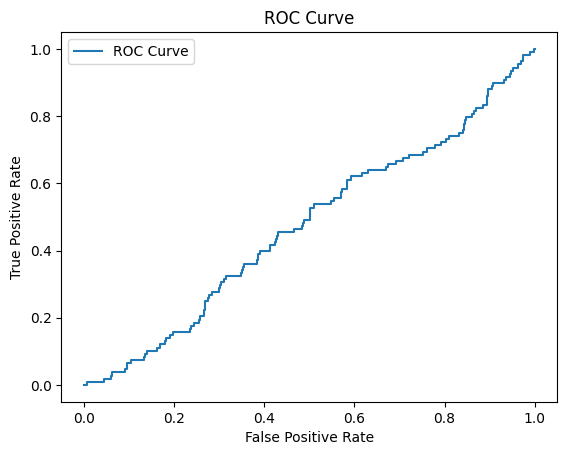

44.86187845303867

In [33]:
# 4. Predict on the test set
y_pred = svm_model.predict(X_test)

# 5. Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

pred_score = svm_model.decision_function(X_test)
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve for binary classification
fpr, tpr, _ = roc_curve(y_test, pred_score, pos_label=1)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
accuracy = (sum(y_test == y_pred))/(len(y_pred))*100
accuracy

In [34]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Train logistic regression on the balanced dataset
logreg = LogisticRegression()
log_model = logreg.fit(X_train_balanced, y_train_balanced)

In [35]:
from sklearn.metrics import classification_report, roc_auc_score
y_pred_unknown = log_model.predict(y_unknown)
y_prob_unknown = log_model.predict_proba(y_unknown)  # Probabilities (optional)


In [ ]:
import numpy as np
unique, counts = np.unique(y_pred_unknown, return_counts=True)
print("Predicted Label Distribution:")
print(dict(zip(unique, counts)))
import matplotlib.pyplot as plt

# Assuming binary classification, plot probabilities for the positive class
plt.hist(y_prob_unknown[:, 1], bins=20, color='blue', alpha=0.7)
plt.title("Prediction Confidence Distribution")
plt.xlabel("Predicted Probability of Positive Class")
plt.ylabel("Frequency")
plt.show()
